In [1]:
!pip install seaborn

In [2]:
!pip install nltk

In [3]:
!pip install tensorflow

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd

2024-10-17 21:40:52.447557: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-17 21:40:52.586271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 21:40:52.641295: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 21:40:52.657394: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 21:40:52.765349: I tensorflow/core/platform/cpu_feature_guar

## Data Loading

In [6]:
# Carregando os datasets de treino e validação
train_file_path = '/teamspace/studios/this_studio/archive (6)/twitter_training.csv' 
validation_file_path = '/teamspace/studios/this_studio/archive (6)/twitter_validation.csv'  

df_train = pd.read_csv(train_file_path)
df_validation = pd.read_csv(validation_file_path)

In [7]:
df_train.columns = ['ID', 'Category', 'Sentiment', 'Tweet']
df_validation.columns = ['ID', 'Category', 'Sentiment', 'Tweet']

# Excluindo linhas com tweets ausentes em ambos os datasets
df_train.dropna(subset=['Tweet'], inplace=True)
df_validation.dropna(subset=['Tweet'], inplace=True)

##  EDA

In [8]:
def analyze_dataset(df, dataset_name):
    print(f"Análise do dataset: {dataset_name}")
    
    # Exibindo informações básicas
    print(df.info())
    
    # Exibindo a contagem de sentimentos
    sentiment_counts = df['Sentiment'].value_counts()
    print(f"\nContagem de sentimentos para {dataset_name}:")
    print(sentiment_counts)
    
    # Visualizando a distribuição dos sentimentos
    plt.figure(figsize=(8, 6))
    sns.countplot(x='Sentiment', data=df, palette='viridis', order=sentiment_counts.index)
    plt.title(f'Distribuição das Classes de Sentimento ({dataset_name})')
    plt.ylabel('Contagem')
    plt.xlabel('Sentimento')
    plt.show()
    
    # Exibindo um exemplo de tweet para cada classe de sentimento
    example_tweets = df.groupby('Sentiment')['Tweet'].first()
    print(f"\nExemplos de tweets de cada classe para {dataset_name}:")
    print(example_tweets)

Análise do dataset: Treino
<class 'pandas.core.frame.DataFrame'>
Index: 73995 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         73995 non-null  int64 
 1   Category   73995 non-null  object
 2   Sentiment  73995 non-null  object
 3   Tweet      73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB
None

Contagem de sentimentos para Treino:
Sentiment
Negative      22358
Positive      20654
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64


/tmp/ipykernel_1866/1148962047.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='viridis', order=sentiment_counts.index)


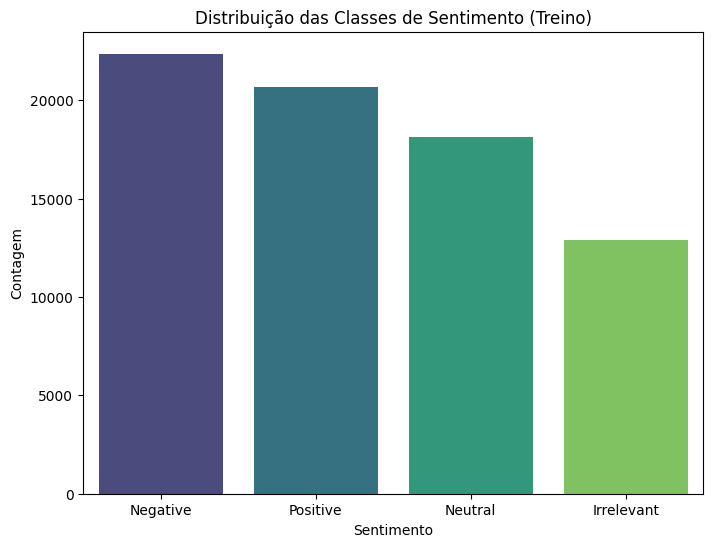


Exemplos de tweets de cada classe para Treino:
Sentiment
Irrelevant    Appreciate the (sonic) concepts / praxis Valen...
Negative      the biggest dissappoinment in my life came out...
Neutral       Rock-Hard La Varlope, RARE & POWERFUL, HANDSOM...
Positive      I am coming to the borders and I will kill you...
Name: Tweet, dtype: object


In [9]:
# Realizando a análise exploratória para o dataset de treino
analyze_dataset(df_train, "Treino")



Análise do dataset: Validação
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         999 non-null    int64 
 1   Category   999 non-null    object
 2   Sentiment  999 non-null    object
 3   Tweet      999 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.3+ KB
None

Contagem de sentimentos para Validação:
Sentiment
Neutral       285
Positive      277
Negative      266
Irrelevant    171
Name: count, dtype: int64


/tmp/ipykernel_1866/1148962047.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='viridis', order=sentiment_counts.index)


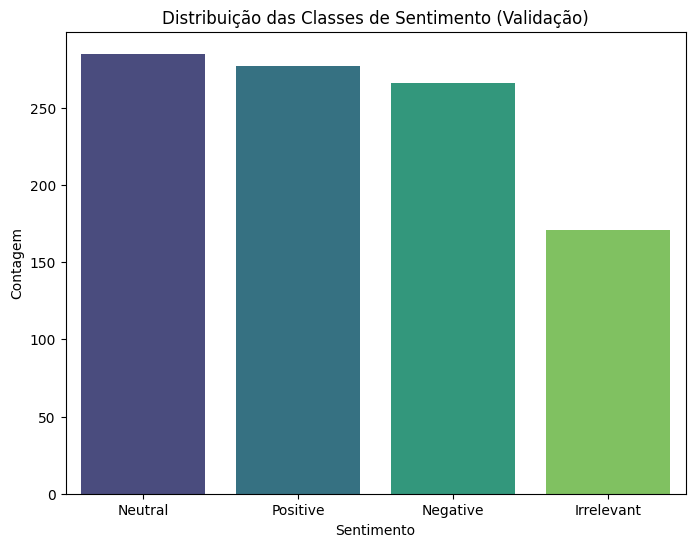


Exemplos de tweets de cada classe para Validação:
Sentiment
Irrelevant    Call of duty warzone (livestream) w/ subs #War...
Negative      @Microsoft Why do I pay for WORD when it funct...
Neutral       BBC News - Amazon boss Jeff Bezos rejects clai...
Positive      Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...
Name: Tweet, dtype: object


In [10]:
# Realizando a análise exploratória para o dataset de validação
analyze_dataset(df_validation, "Validação")

## Functions

In [11]:
class MetricsCallback:
    def __init__(self):
        self.train_accuracy = []
        self.val_accuracy = []
        self.train_f1 = []
        self.val_f1 = []
        self.train_precision = []
        self.val_precision = []
        self.train_recall = []
        self.val_recall = []
        self.train_loss = []
        self.val_loss = []

    def update_metrics(self, epoch, y_true_train, y_pred_train, y_true_val, y_pred_val, train_loss, val_loss):
        y_pred_train = torch.argmax(y_pred_train, dim=1).cpu().numpy()
        y_pred_val = torch.argmax(y_pred_val, dim=1).cpu().numpy()

        # Calculando as métricas para o conjunto de treino
        train_acc = (y_true_train == y_pred_train).mean()
        train_f1 = f1_score(y_true_train, y_pred_train, average='weighted')
        train_precision = precision_score(y_true_train, y_pred_train, average='weighted')
        train_recall = recall_score(y_true_train, y_pred_train, average='weighted')

        # Calculando as métricas para o conjunto de validação
        val_acc = (y_true_val == y_pred_val).mean()
        val_f1 = f1_score(y_true_val, y_pred_val, average='weighted')
        val_precision = precision_score(y_true_val, y_pred_val, average='weighted')
        val_recall = recall_score(y_true_val, y_pred_val, average='weighted')

        # Armazenando as métricas e a perda
        self.train_accuracy.append(train_acc)
        self.val_accuracy.append(val_acc)
        self.train_f1.append(train_f1)
        self.val_f1.append(val_f1)
        self.train_precision.append(train_precision)
        self.val_precision.append(val_precision)
        self.train_recall.append(train_recall)
        self.val_recall.append(val_recall)
        self.train_loss.append(train_loss)
        self.val_loss.append(val_loss)

        # Exibindo as métricas no final de cada época
        print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
        print(f"Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")


In [12]:
def plot_metrics(metrics_callback):
    epochs = range(1, len(metrics_callback.train_accuracy) + 1)

    plt.figure(figsize=(12, 10))
    
    # Plotando a acurácia
    plt.subplot(2, 3, 1)
    plt.plot(epochs, metrics_callback.train_accuracy, label='Train Accuracy')
    plt.plot(epochs, metrics_callback.val_accuracy, label='Val Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotando o F1-Score
    plt.subplot(2, 3, 2)
    plt.plot(epochs, metrics_callback.train_f1, label='Train F1-Score')
    plt.plot(epochs, metrics_callback.val_f1, label='Val F1-Score')
    plt.title('F1-Score per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()

    # Plotando a precisão
    plt.subplot(2, 3, 3)
    plt.plot(epochs, metrics_callback.train_precision, label='Train Precision')
    plt.plot(epochs, metrics_callback.val_precision, label='Val Precision')
    plt.title('Precision per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Plotando o recall
    plt.subplot(2, 3, 4)
    plt.plot(epochs, metrics_callback.train_recall, label='Train Recall')
    plt.plot(epochs, metrics_callback.val_recall, label='Val Recall')
    plt.title('Recall per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    # Plotando a perda (loss)
    plt.subplot(2, 3, 5)
    plt.plot(epochs, metrics_callback.train_loss, label='Train Loss')
    plt.plot(epochs, metrics_callback.val_loss, label='Val Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5, patience=3, min_delta=0.001):
    metrics_callback = MetricsCallback()
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)  
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        all_train_preds = []
        all_train_labels = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            all_train_preds.append(outputs.detach())
            all_train_labels.append(labels.detach())

        model.eval()
        val_loss = 0.0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                all_val_preds.append(outputs)
                all_val_labels.append(labels)

        all_train_preds = torch.cat(all_train_preds)
        all_train_labels = torch.cat(all_train_labels)
        all_val_preds = torch.cat(all_val_preds)
        all_val_labels = torch.cat(all_val_labels)

        # Atualizando as métricas ao final de cada época
        metrics_callback.update_metrics(
            epoch,
            all_train_labels.cpu().numpy(),
            all_train_preds.cpu(),
            all_val_labels.cpu().numpy(),
            all_val_preds.cpu(),
            train_loss / len(train_loader),
            val_loss / len(val_loader)
        )

        # Verificar Early Stopping com base no val_loss
        early_stopping(val_loss / len(val_loader))
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Retornando as métricas ao final do treinamento para plotar
    return metrics_callback


In [14]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        # Se for a primeira época, define o melhor loss
        if self.best_loss is None:
            self.best_loss = val_loss
        # Verifica se a melhora em val_loss é significativa
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        # Se o val_loss melhorar, reseta o contador
        else:
            self.best_loss = val_loss
            self.counter = 0


## Data Cleaning

In [15]:
def clean_tweet(tweet):
    # Convertendo para minúsculas
    tweet = tweet.lower()
    
    # Removendo URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    
    # Removendo menções (@usuário)
    tweet = re.sub(r'@\w+', '', tweet)
    
    # Removendo caracteres especiais, exceto espaços, letras e números
    tweet = re.sub(r'[^A-Za-z0-9\s]', '', tweet)
    
    # Removendo múltiplos espaços
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    
        
    return tweet

In [16]:
df_train['Cleaned_Tweet'] = df_train['Tweet'].apply(clean_tweet)
df_validation['Cleaned_Tweet'] = df_validation['Tweet'].apply(clean_tweet)

In [17]:
df_train.drop_duplicates(subset=['Cleaned_Tweet'], inplace=True)
df_validation.drop_duplicates(subset=['Cleaned_Tweet'], inplace=True)

In [18]:
print("\nExemplo de tweet original e limpo (Treino):")
print(f"Original: {df_train['Tweet'].iloc[0]}")
print(f"Limpo: {df_train['Cleaned_Tweet'].iloc[0]}")


Exemplo de tweet original e limpo (Treino):
Original: I am coming to the borders and I will kill you all,
Limpo: i am coming to the borders and i will kill you all


## Models

### LSTM

#### Data Preprocessing/Model

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [20]:
X_train = df_train.iloc[:, 3].fillna('').astype(str).values  # Tratar valores nulos e converter para string
y_train = df_train.iloc[:, 2].values  # 3ª coluna para sentimento

X_val = df_validation.iloc[:, 3].fillna('').astype(str).values  # Tratar valores nulos e converter para string
y_val = df_validation.iloc[:, 2].values  # 3ª coluna para sentimento

In [21]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)


In [22]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [23]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)


In [24]:
# Padronizando o comprimento das sequências
max_len = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')

In [25]:
train_dataset = TensorDataset(torch.tensor(X_train_pad, dtype=torch.long), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val_pad, dtype=torch.long), torch.tensor(y_val, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [26]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, vocab_size, embedding_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  # Pegando a última saída da LSTM
        out = self.fc(lstm_out)
        return out

In [27]:
vocab_size = 10000
embedding_dim = 64
hidden_dim = 128
output_dim = 4

In [28]:
model = LSTMClassifier(input_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=output_dim, vocab_size=vocab_size, embedding_dim=embedding_dim)
model.to(device)

LSTMClassifier(
  (embedding): Embedding(10000, 64)
  (lstm): LSTM(64, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
metrics_callback = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=3, min_delta=0.001)


Epoch 1 - Train Loss: 1.3350, Val Loss: 1.1946
Train Acc: 0.3446, Train F1: 0.2769, Train Precision: 0.3453, Train Recall: 0.3446
Val Acc: 0.4910, Val F1: 0.4475, Val Precision: 0.5776, Val Recall: 0.4910
Epoch 2 - Train Loss: 1.0753, Val Loss: 0.8404
Train Acc: 0.5554, Train F1: 0.5146, Train Precision: 0.5489, Train Recall: 0.5554
Val Acc: 0.6767, Val F1: 0.6513, Val Precision: 0.6670, Val Recall: 0.6767
Epoch 3 - Train Loss: 0.8092, Val Loss: 0.5776
Train Acc: 0.6867, Train F1: 0.6768, Train Precision: 0.6768, Train Recall: 0.6867
Val Acc: 0.7821, Val F1: 0.7791, Val Precision: 0.7795, Val Recall: 0.7821
Epoch 4 - Train Loss: 0.5831, Val Loss: 0.4237
Train Acc: 0.7857, Train F1: 0.7836, Train Precision: 0.7834, Train Recall: 0.7857
Val Acc: 0.8424, Val F1: 0.8399, Val Precision: 0.8411, Val Recall: 0.8424
Epoch 5 - Train Loss: 0.4115, Val Loss: 0.3208
Train Acc: 0.8542, Train F1: 0.8535, Train Precision: 0.8536, Train Recall: 0.8542
Val Acc: 0.8996, Val F1: 0.8991, Val Precision: 0.

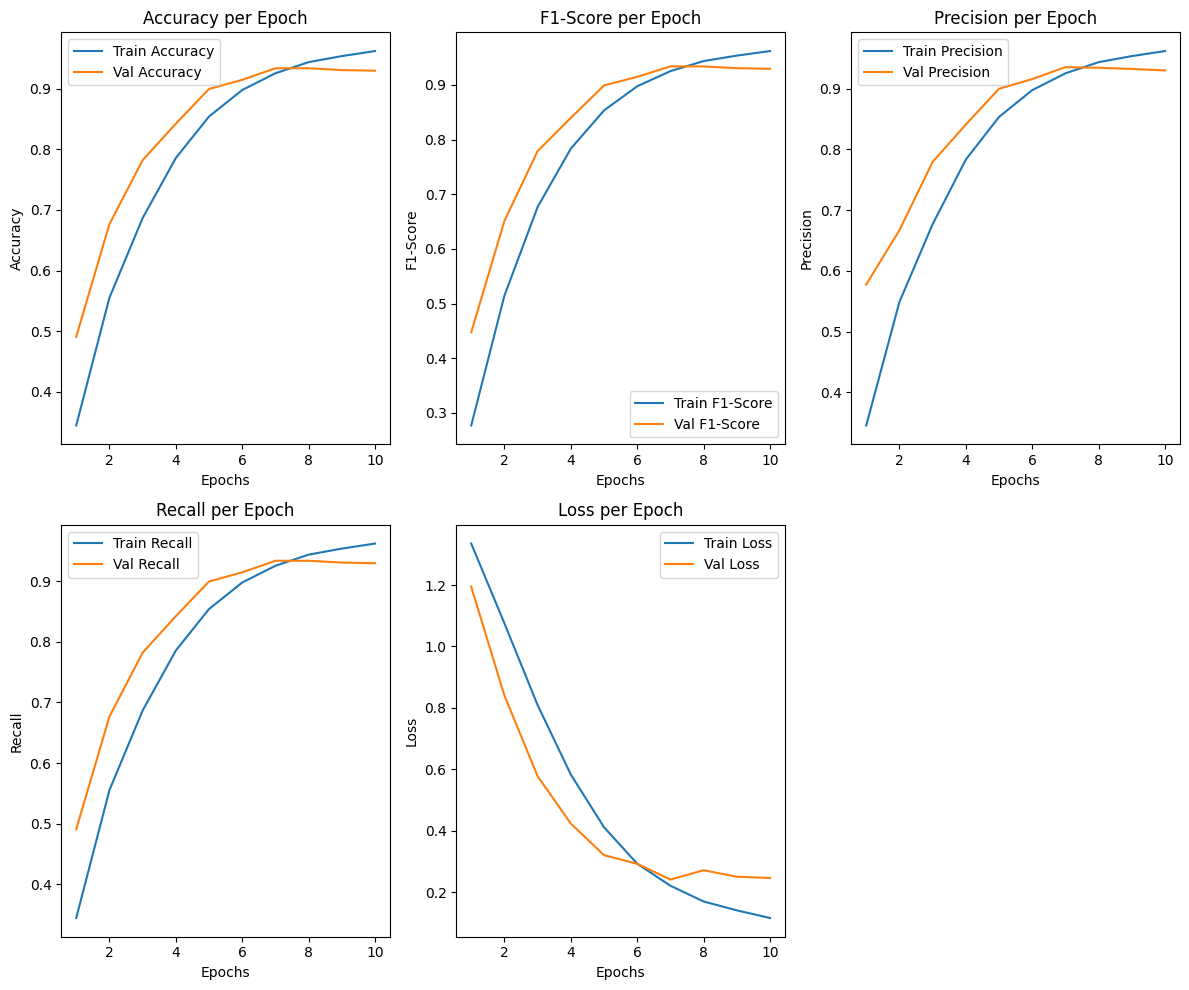

In [31]:
plot_metrics(metrics_callback)


In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [33]:
model.eval()
all_val_preds = []
all_val_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        all_val_preds.append(outputs)
        all_val_labels.append(labels)


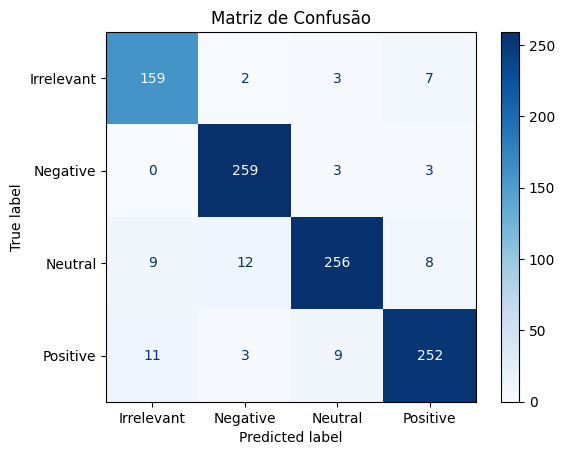

In [34]:
all_val_preds = torch.cat(all_val_preds)
all_val_labels = torch.cat(all_val_labels)

# Convertendo as previsões para rótulos
y_pred_val = torch.argmax(all_val_preds, dim=1).cpu().numpy()
y_true_val = all_val_labels.cpu().numpy()

# Calculando a matriz de confusão
cm = confusion_matrix(y_true_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()

### GRU

In [35]:
# Definindo o modelo GRU
class GRUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, vocab_size, embedding_dim):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        gru_out = gru_out[:, -1, :]  # Pegando a última saída da GRU
        out = self.fc(gru_out)
        return out


In [36]:
model = GRUClassifier(input_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=output_dim, vocab_size=vocab_size, embedding_dim=embedding_dim)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [37]:
metrics_callback = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=3, min_delta=0.001)


Epoch 1 - Train Loss: 1.2017, Val Loss: 0.9230
Train Acc: 0.4593, Train F1: 0.4178, Train Precision: 0.4562, Train Recall: 0.4593
Val Acc: 0.6376, Val F1: 0.6016, Val Precision: 0.6443, Val Recall: 0.6376
Epoch 2 - Train Loss: 0.8451, Val Loss: 0.5653
Train Acc: 0.6636, Train F1: 0.6546, Train Precision: 0.6544, Train Recall: 0.6636
Val Acc: 0.7932, Val F1: 0.7936, Val Precision: 0.7947, Val Recall: 0.7932
Epoch 3 - Train Loss: 0.5606, Val Loss: 0.3526
Train Acc: 0.7905, Train F1: 0.7893, Train Precision: 0.7895, Train Recall: 0.7905
Val Acc: 0.8926, Val F1: 0.8920, Val Precision: 0.8932, Val Recall: 0.8926
Epoch 4 - Train Loss: 0.3592, Val Loss: 0.2500
Train Acc: 0.8705, Train F1: 0.8703, Train Precision: 0.8704, Train Recall: 0.8705
Val Acc: 0.9227, Val F1: 0.9227, Val Precision: 0.9236, Val Recall: 0.9227
Epoch 5 - Train Loss: 0.2411, Val Loss: 0.2216
Train Acc: 0.9173, Train F1: 0.9172, Train Precision: 0.9174, Train Recall: 0.9173
Val Acc: 0.9317, Val F1: 0.9322, Val Precision: 0.

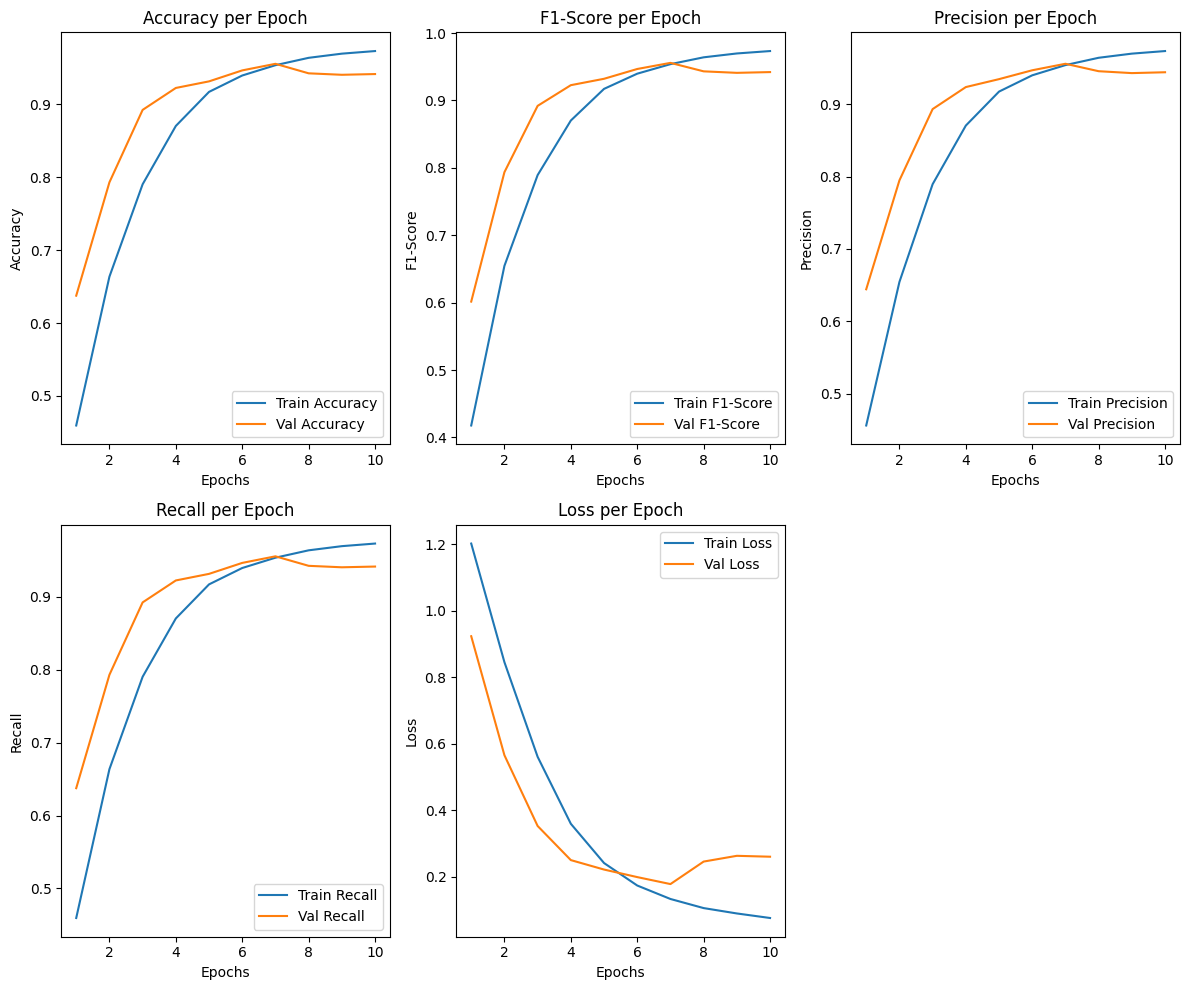

In [38]:
plot_metrics(metrics_callback)


In [39]:
model.eval()
all_val_preds = []
all_val_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        all_val_preds.append(outputs)
        all_val_labels.append(labels)


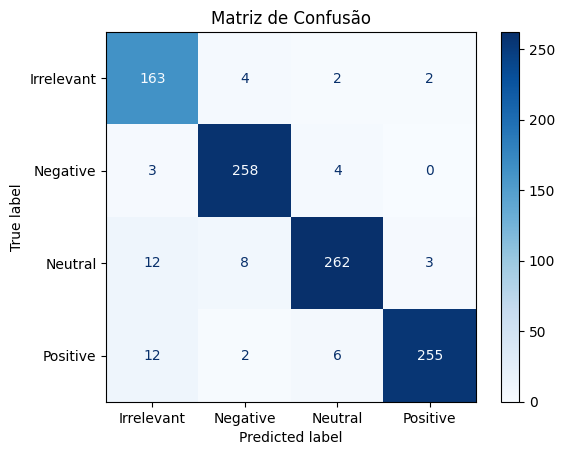

In [40]:
all_val_preds = torch.cat(all_val_preds)
all_val_labels = torch.cat(all_val_labels)

# Convertendo as previsões para rótulos
y_pred_val = torch.argmax(all_val_preds, dim=1).cpu().numpy()
y_true_val = all_val_labels.cpu().numpy()

# Calculando a matriz de confusão
cm = confusion_matrix(y_true_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()

### Bi-LSTM

In [41]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, vocab_size, embedding_dim):
        super(BiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiplica por 2 por ser bidirecional

    def forward(self, x):
        embedded = self.embedding(x)
        bilstm_out, _ = self.bilstm(embedded)
        bilstm_out = bilstm_out[:, -1, :]  # Pegando a última saída da Bi-LSTM
        out = self.fc(bilstm_out)
        return out

In [42]:
model = BiLSTMClassifier(input_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=output_dim, vocab_size=vocab_size, embedding_dim=embedding_dim)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:
metrics_callback = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=3, min_delta=0.001)


Epoch 1 - Train Loss: 1.2957, Val Loss: 1.1031
Train Acc: 0.3865, Train F1: 0.3302, Train Precision: 0.4071, Train Recall: 0.3865
Val Acc: 0.5382, Val F1: 0.4881, Val Precision: 0.5588, Val Recall: 0.5382
Epoch 2 - Train Loss: 1.0062, Val Loss: 0.8077
Train Acc: 0.5929, Train F1: 0.5630, Train Precision: 0.5769, Train Recall: 0.5929
Val Acc: 0.6968, Val F1: 0.6743, Val Precision: 0.6889, Val Recall: 0.6968
Epoch 3 - Train Loss: 0.7573, Val Loss: 0.5307
Train Acc: 0.7098, Train F1: 0.7023, Train Precision: 0.7028, Train Recall: 0.7098
Val Acc: 0.8203, Val F1: 0.8182, Val Precision: 0.8187, Val Recall: 0.8203
Epoch 4 - Train Loss: 0.5422, Val Loss: 0.3947
Train Acc: 0.8033, Train F1: 0.8012, Train Precision: 0.8019, Train Recall: 0.8033
Val Acc: 0.8775, Val F1: 0.8763, Val Precision: 0.8766, Val Recall: 0.8775
Epoch 5 - Train Loss: 0.3819, Val Loss: 0.3455
Train Acc: 0.8661, Train F1: 0.8655, Train Precision: 0.8659, Train Recall: 0.8661
Val Acc: 0.8986, Val F1: 0.8976, Val Precision: 0.

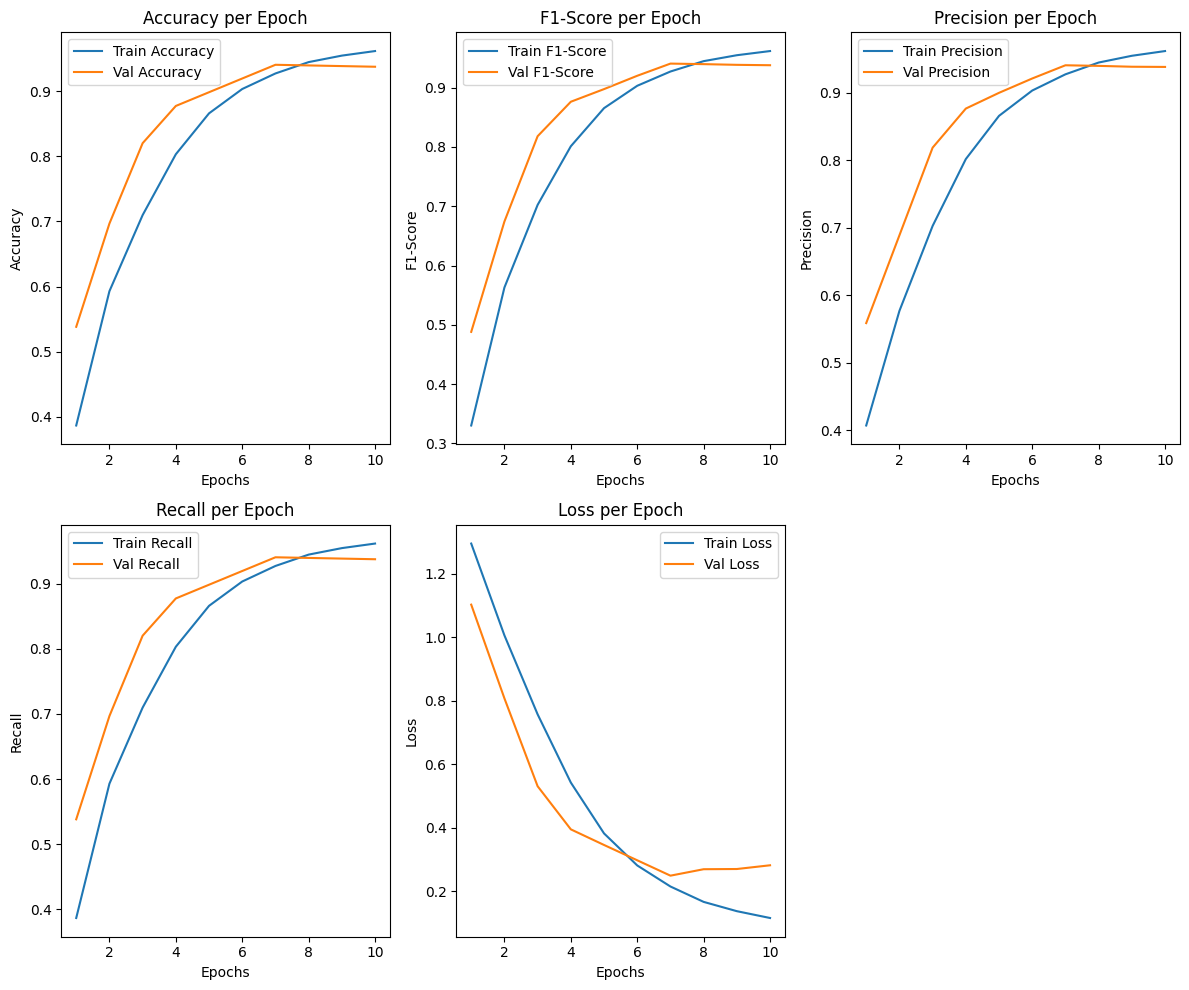

In [44]:
plot_metrics(metrics_callback)


In [45]:
model.eval()
all_val_preds = []
all_val_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        all_val_preds.append(outputs)
        all_val_labels.append(labels)

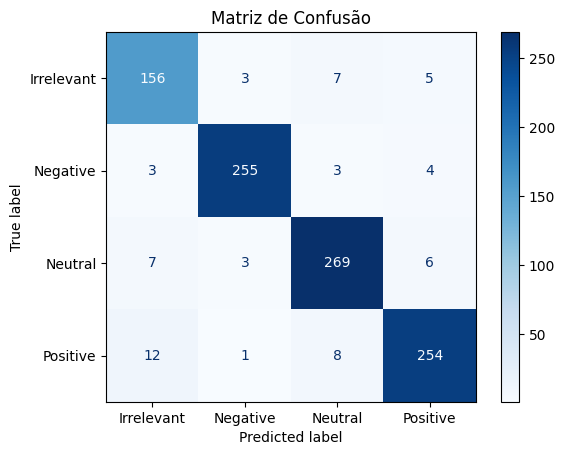

In [46]:
all_val_preds = torch.cat(all_val_preds)
all_val_labels = torch.cat(all_val_labels)

# Convertendo as previsões para rótulos
y_pred_val = torch.argmax(all_val_preds, dim=1).cpu().numpy()
y_true_val = all_val_labels.cpu().numpy()

# Calculando a matriz de confusão
cm = confusion_matrix(y_true_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()

### Text-CNN

In [47]:
import torch.nn.functional as F


In [48]:
class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, kernel_sizes, num_filters):
        super(CNNTextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Camadas de convolução com diferentes tamanhos de filtro
        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(k, embedding_dim)) for k in kernel_sizes
        ])
        
        # Camada densa final
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, output_dim)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # Adiciona uma dimensão de canal (batch, 1, seq_len, embed_dim)
        
        # Aplicando convoluções e ReLU
        conved = [F.relu(conv(x)).squeeze(3) for conv in self.conv_layers]
        
        # Max-pooling para reduzir a dimensionalidade
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        # Concatenando as saídas das diferentes convoluções
        cat = torch.cat(pooled, dim=1)
        
        # Passando pela camada densa final
        return self.fc(cat)

In [49]:
vocab_size = 10000
embedding_dim = 64
output_dim = 4  # Número de classes (positivo, negativo, neutro, irrelevante)
kernel_sizes = [3, 4, 5]  # Tamanhos dos filtros (n-gramas de 3, 4 e 5 palavras)
num_filters = 100  # Número de filtros por tamanho de kernel

In [50]:
model = CNNTextClassifier(vocab_size=vocab_size, embedding_dim=embedding_dim, output_dim=output_dim, kernel_sizes=kernel_sizes, num_filters=num_filters)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [51]:
metrics_callback = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=3, min_delta=0.001)


Epoch 1 - Train Loss: 1.0372, Val Loss: 0.6111
Train Acc: 0.5664, Train F1: 0.5566, Train Precision: 0.5630, Train Recall: 0.5664
Val Acc: 0.8082, Val F1: 0.8091, Val Precision: 0.8128, Val Recall: 0.8082
Epoch 2 - Train Loss: 0.5829, Val Loss: 0.3228
Train Acc: 0.7926, Train F1: 0.7916, Train Precision: 0.7920, Train Recall: 0.7926
Val Acc: 0.9066, Val F1: 0.9068, Val Precision: 0.9119, Val Recall: 0.9066
Epoch 3 - Train Loss: 0.3136, Val Loss: 0.2063
Train Acc: 0.9021, Train F1: 0.9020, Train Precision: 0.9021, Train Recall: 0.9021
Val Acc: 0.9367, Val F1: 0.9368, Val Precision: 0.9378, Val Recall: 0.9367
Epoch 4 - Train Loss: 0.1746, Val Loss: 0.1689
Train Acc: 0.9499, Train F1: 0.9499, Train Precision: 0.9500, Train Recall: 0.9499
Val Acc: 0.9458, Val F1: 0.9459, Val Precision: 0.9470, Val Recall: 0.9458
Epoch 5 - Train Loss: 0.1045, Val Loss: 0.1425
Train Acc: 0.9719, Train F1: 0.9719, Train Precision: 0.9720, Train Recall: 0.9719
Val Acc: 0.9608, Val F1: 0.9608, Val Precision: 0.

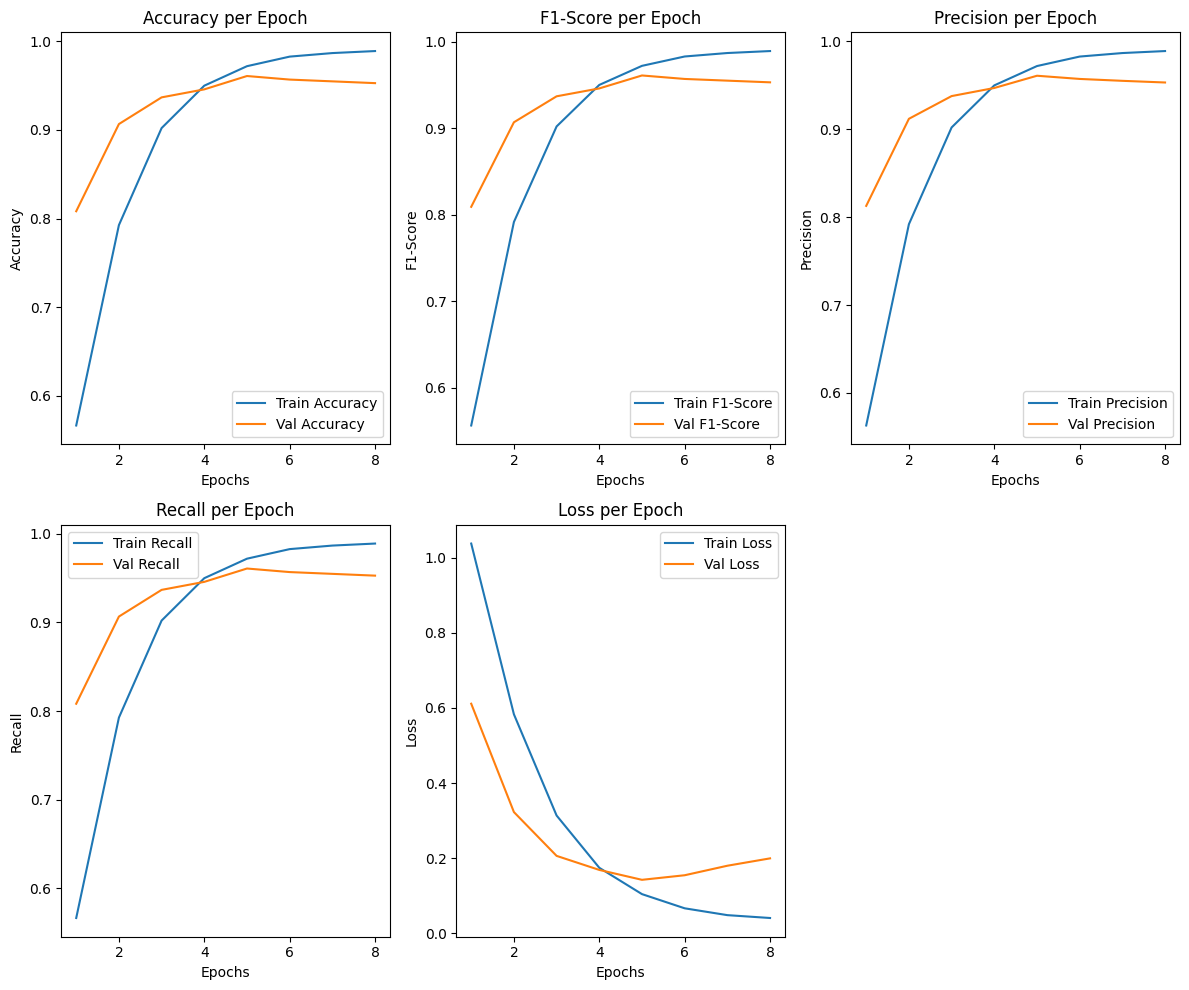

In [52]:
plot_metrics(metrics_callback)


In [53]:
model.eval()
all_val_preds = []
all_val_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        all_val_preds.append(outputs)
        all_val_labels.append(labels)

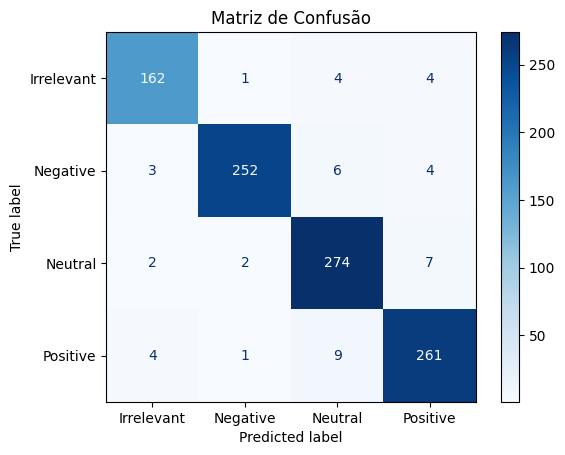

In [54]:
all_val_preds = torch.cat(all_val_preds)
all_val_labels = torch.cat(all_val_labels)

# Convertendo as previsões para rótulos
y_pred_val = torch.argmax(all_val_preds, dim=1).cpu().numpy()
y_true_val = all_val_labels.cpu().numpy()

# Calculando a matriz de confusão
cm = confusion_matrix(y_true_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()